###### Оглавление

1. Описание выборки

2. Сбор финальной таблицы для обучения

3. Статитика по файлам

4. Качество парсинга

5. Результаты работы моделей

    4.1 Логистическая регрессия на кросс-валидации
    
    4.2 Random Forest
    
    4.3 Catboost
    
6. Финальный таблица с метриками для разных моделей



# Описание выборки
###### Весь написанный код лежит тут:
https://cloud.mail.ru/public/48Bs/kiTBEWaaC

    В папке script1 pipeline для запуска извлечения текстов из документов
    В папке notebooks все промежуточные ноутбуки

    В папке data - данные полученные для обучения модели
           префикс tf-idf          - sklearn.feature_extraction.text.CountVectorizer
                   count-vect      - sklearn.feature_extraction.text.TfidfVectorizer

           M     - разряженная матрица с признаками (20000 признаков)
           vect  - векторайзер (vect.vocabulary_ - содержит словарь со словами)
           df     - DataFrame с описанием всех фалов (порядок строк соответсвует M)
               'fn'  : путь к файлу на компьютере сбера 
                       (путь содержит название файла, оттуда тоже можно достать признаки)
                       
               'file_size' : размер файла в Кб
               
               'y'         : 1 для конфиденциальных, 0 для не конфиденциальных
               
               'ID'        : ID файла в формате {тип_документа}_{размер фала в байтах}_{дата_создания}_{префикс к
                              папке залитой из ЦЭОДО}_{случайное число}
                              
               'ts'        : Дата создания файла на коспьютере
               
               'permited_file_type' : True для офисных документов
               
               'name'               : Название файлы из 'fn'        
               
               'type'               : Тип документа
               
               'parsed'             : Был ли коррекстно распаршен файл

    Файлы импортируются так (должно работать для всех 64-разрядных ОС)

    import pickle
    fn = 'data/count_vect_M.pickle'
    M = pickle.load(open(fn, 'rb'))

# Сбор финальной таблицы для обучения

#### Импорт библиотек

In [ ]:
import os, sys
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#### Переменные для запуска этого ноутбука

In [2]:
# Игнорировать нераспаршенные файлы

# Способ преобразования признаков (count_vect или tf_idf)
vect_name = 'tf_idf' # or tf_idf
alpha     = 0.25 

Загружаем данные полученные со сбера

In [3]:
fn_M    = '../data/res/%s_M.pickle'%vect_name
fn_df   = '../data/res/%s_df.pickle'%vect_name
fn_vect = '../data/res/%s_vect.pickle'%vect_name

M    = pickle.load(open(fn_M, 'rb'))
vect = pickle.load(open(fn_vect, 'rb'))
df   = pickle.load(open(fn_df, 'rb'))

print("M.shape  = ", M.shape)
print('df.shape = ', df.shape)

/usr/local/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


M.shape  =  (33373, 20000)
df.shape =  (33373, 9)


/usr/local/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Собираем финальную таблицу с признаками

In [9]:
dct = vect.vocabulary_
dct_inv = {v:k for k,v in dct.items()}

features = ['w_'+i[0] for i in sorted(dct.items(), key = lambda x:x[0])]
data = pd.DataFrame(M.toarray(), columns = features, index = df.index)
data = df.join(data)
data

,fn,file_size,y,ID,ts,permited_file_type,name,type,parsed,w_00,...,w_ястребов,w_яхьяев,w_яцунов,w_яч,w_ячейка,w_яшагин,w_яшин,w_ященко,w_ящик,w_яя
csv_13857_2019-04-02_b209,D://SEODO_not_conf/b2094682-f661-45f0-933e-5a4...,13.857422,0,csv_13857_2019-04-02_b209_22547,2019-04-02 18:28:58.000,False,ресурсы 4.1_N33.csv,csv,False,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_100000_2018-10-03_1705,D://SEODO_not_conf/1705fea8-4370-4dfb-adee-dfc...,100.000000,0,doc_100000_2018-10-03_1705_03082,2018-10-03 20:35:30.000,True,Распоряжение по мероприятиям (ПОЖ)2017.doc,doc,False,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_100000_2018-10-03_3b50,D://SEODO_not_conf/3b502918-96b0-4d2f-a1c1-387...,100.000000,0,doc_100000_2018-10-03_3b50_07551,2018-10-03 21:13:14.000,True,распоряжение_99-05-32.doc,doc,True,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_100000_2018-10-03_526e,D://SEODO_not_conf/526e1acc-da2c-4b79-8ce4-514...,100.000000,0,doc_100000_2018-10-03_526e_10500,2018-10-03 19:10:34.000,True,SAMA (евро).doc,doc,True,0.043112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_100000_2018-10-03_ba7a,D://SEODO_not_conf/ba7adde2-0e30-4e84-ae8c-a40...,100.000000,0,doc_100000_2018-10-03_ba7a_23601,2018-10-03 16:51:20.000,True,Распоряжение %%.doc,doc,True,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_100000_2018-10-03_ece6,D://SEODO_not_conf/ece6a9b7-e28a-4f7c-bee4-103...,100.000000,0,doc_100000_2018-10-03_ece6_29996,2018-10-03 19:56:56.000,True,Распоряжение.doc,doc,True,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_100000_2018-10-03_f02f,D://SEODO_not_conf/f02f85da-d7a7-4875-a249-4c2...,100.000000,0,doc_100000_2018-10-03_f02f_30390,2018-10-03 18:09:02.000,True,Распоряжение о назначении администраторов АС Н...,doc,True,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_100000_2018-10-04_a01f,D://SEODO_not_conf/a01f4e0e-6d5e-4b6b-aad9-ffb...,100.000000,0,doc_100000_2018-10-04_a01f_20203,2018-10-04 11:25:36.000,True,Распоряжение об утверждении пред штат численно...,doc,True,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_100500_2018-10-03_4587,D://SEODO_not_conf/45878336-40f4-4940-8587-641...,100.500000,0,doc_100500_2018-10-03_4587_08881,2018-10-03 18:03:52.000,True,Распоряжение на допуск в КИЦ-2.2.doc,doc,True,0.040532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
doc_101000_2018-10-03_2eaf,D://SEODO_not_conf/2eaf7052-64fa-4cac-aa86-c93...,101.000000,0,doc_101000_2018-10-03_2eaf_05882,2018-10-03 21:10:52.000,True,Распоряжение о проведении проверки ПП39 .doc,doc,True,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


Сохранение финальной таблицы (может занять время)

In [26]:
pickle.dump(data, open('data_%s.pickle'%vect_name, 'wb'))

OverflowError: cannot serialize a bytes object larger than 4 GiB

In [27]:
# # data = data.reset_index()
data.to_excel('data_%s.xlsx'%vect_name)

В дальнейшем в этом ноутбуке я буду использовать формат M, vect и df

(так задействуется меньше оперативной памяти)

In [30]:
del data

Load data

# Статитика по файлам

#### 3.1.1 Распределение типов документов

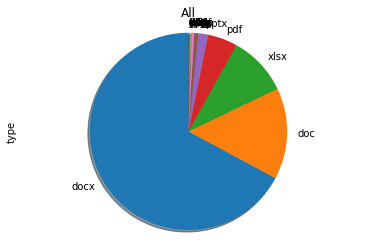

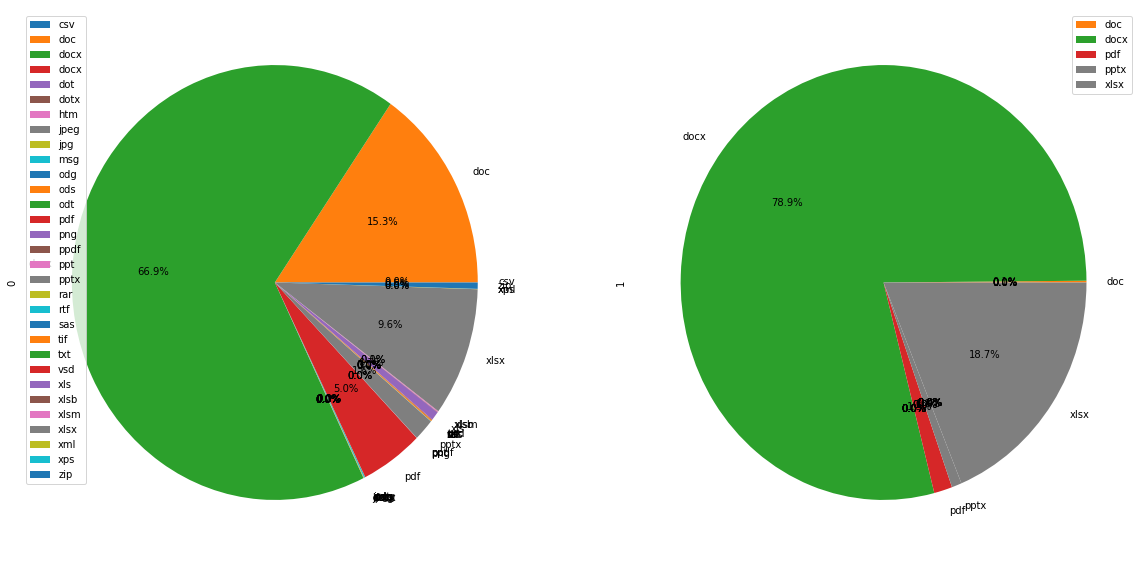

In [120]:
df['type'].value_counts().plot.pie(title ='All', shadow = True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

pd.DataFrame({'0':df[df['y']==0]['type'].value_counts(), 
              '1':df[df['y']==1]['type'].value_counts()}).plot.pie( subplots = True, figsize = (20, 10), autopct='%2.1f%%')
plt.show()

Комментарий: 

Видно что в выборке сильно отличаются типы документов, далее будет рассмотрена модель которая в качестви признака берет только тип документа и уровень парсинга

#### 3.1.2 Распределение  размеров файлов


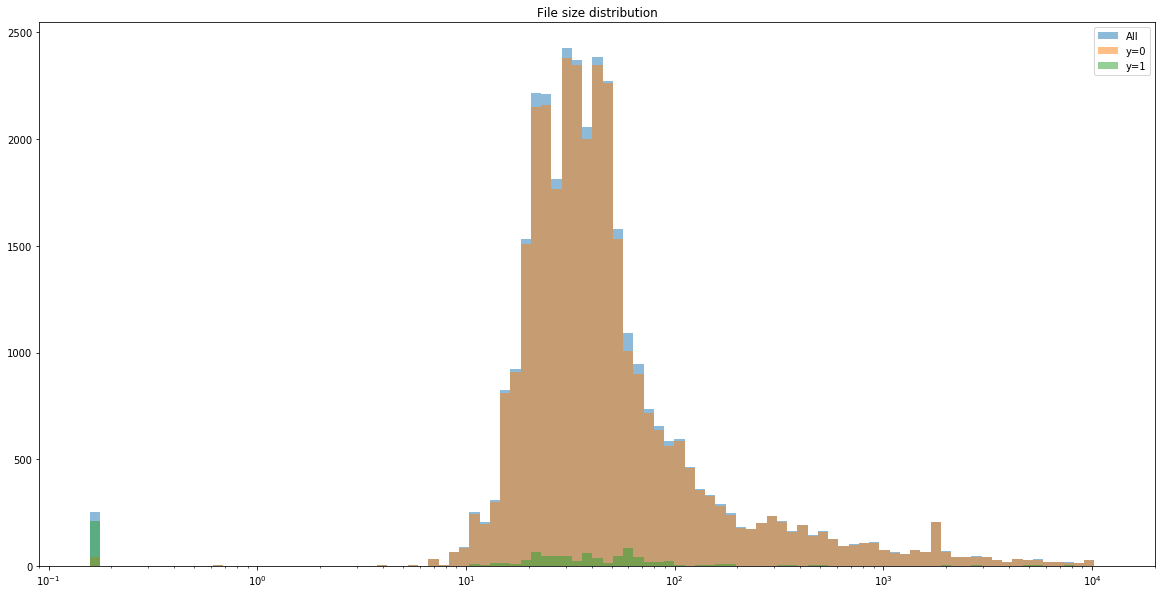

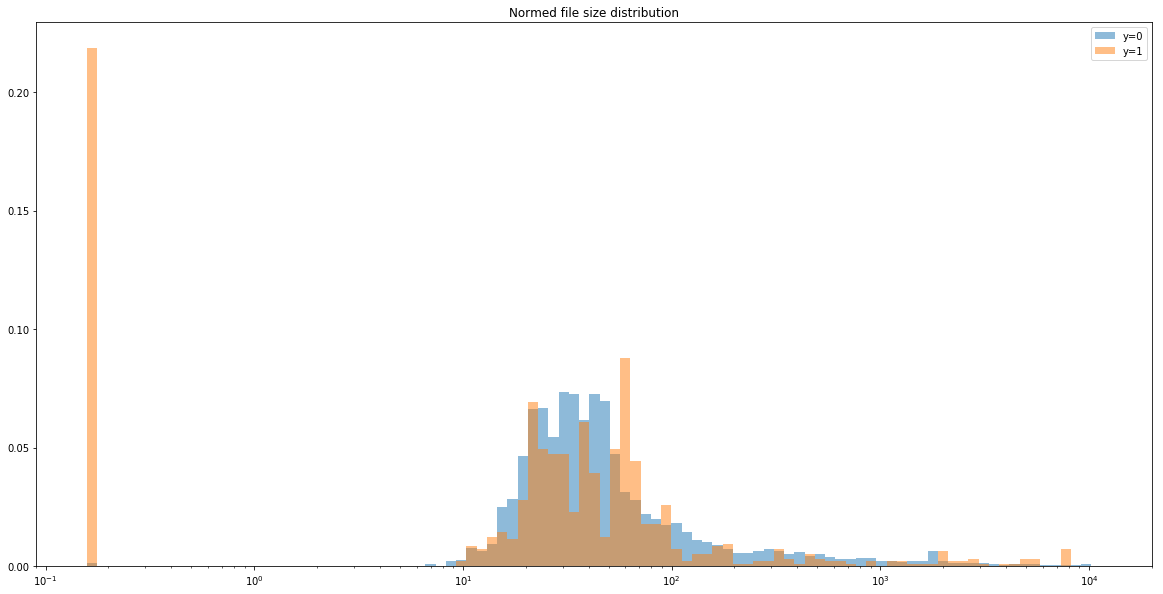

In [111]:
# plt.hist(df['file_size'], bins = 100)
# plt.subplot(211)
# hist, bins, _ = plt.hist(x, bins=8)

# # histogram on log scale. 
# # Use non-equal bin sizes, such that they look equal on log scale.
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# plt.subplot(212)
# plt.hist(x, bins=logbins)
plt.figure(figsize = (20, 10))
plt.title('File size distribution')
plt.xscale('log')
bins = np.logspace(np.log10(df['file_size'].min()), np.log10(df['file_size'].max()), 100)
plt.hist(df['file_size'], bins, alpha = 0.5, label = 'All')
plt.hist(df[df['y']==0]['file_size'], bins, label = 'y=0', alpha = 0.5)
plt.hist(df[df['y']==1]['file_size'], bins, label = 'y=1', alpha = 0.5)
plt.xlabel('Size [kb]')
plt.ylabel('Number of files')
plt.legend()
plt.show()

plt.figure(figsize = (20, 10))
plt.title('Normed file size distribution')
plt.xscale('log')
_n = len(df[df['y']==0])
weights = np.ones(_n)/_n
plt.hist(df[df['y']==0]['file_size'], bins, weights=weights, label = 'y=0', alpha = 0.5)
_n = len(df[df['y']==1])
weights = np.ones(_n)/_n
plt.hist(df[df['y']==1]['file_size'], bins, weights=weights, label = 'y=1', alpha = 0.5)
plt.xlabel('Size [kb]')
plt.ylabel('Fraction of files')
plt.legend()
plt.show()



# df['file_size'].hist()


Комментарий:

Пик слева - системные файлы с префиксом '~$'

Распределения - логнормальные

In [133]:
df[df['fn'].apply(lambda x : '~$' in x)].shape

(254, 9)

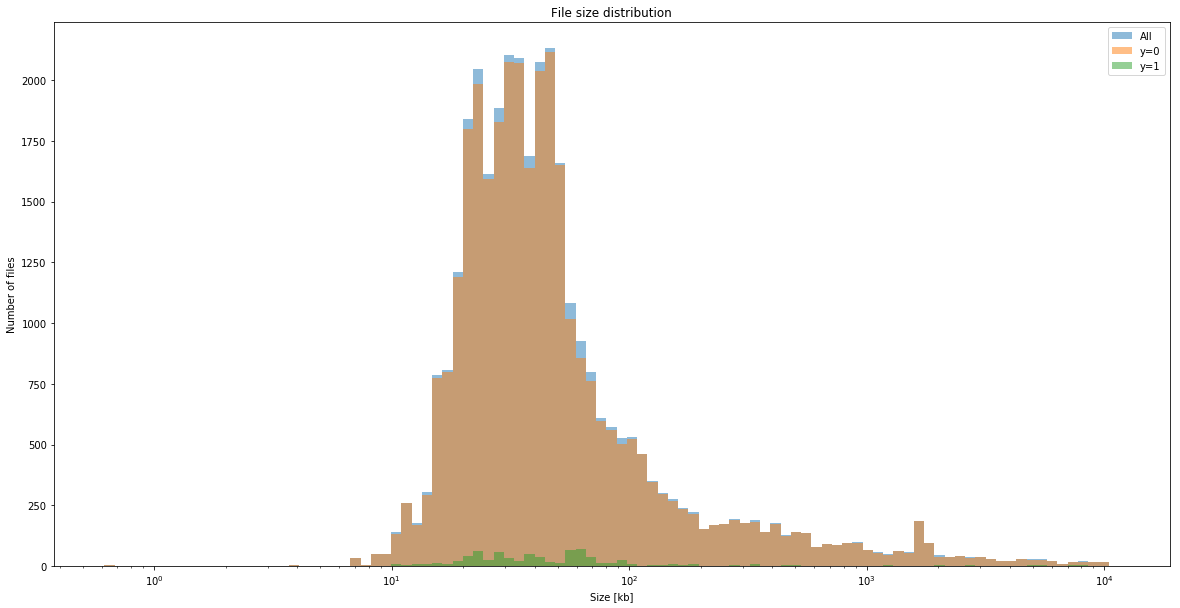

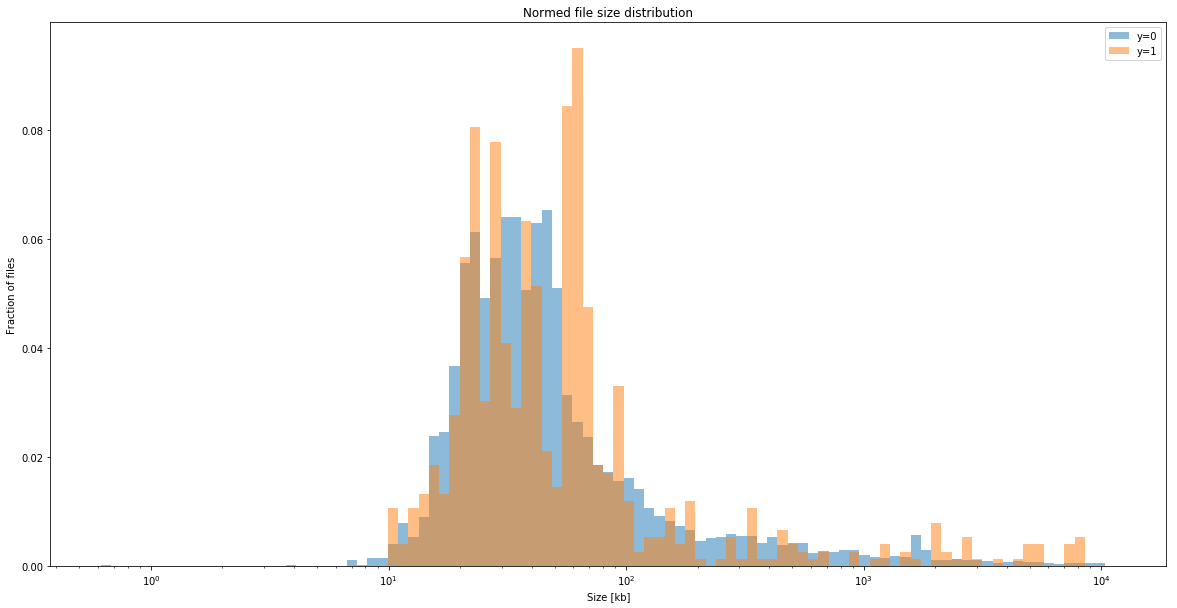

In [121]:
d = df[df['fn'].apply(lambda x : '~$' not in x)]
plt.figure(figsize = (20, 10))
plt.title('File size distribution')
plt.xscale('log')
bins = np.logspace(np.log10(d['file_size'].min()), np.log10(d['file_size'].max()), 100)
plt.hist(d['file_size'], bins, alpha = 0.5, label = 'All')
plt.hist(d[d['y']==0]['file_size'], bins, label = 'y=0', alpha = 0.5)
plt.hist(d[d['y']==1]['file_size'], bins, label = 'y=1', alpha = 0.5)
plt.xlabel('Size [kb]')
plt.ylabel('Number of files')
plt.legend()
plt.show()

plt.figure(figsize = (20, 10))
plt.title('Normed file size distribution')
plt.xscale('log')
_n = len(d[d['y']==0])
weights = np.ones(_n)/_n
plt.hist(d[d['y']==0]['file_size'], bins, weights=weights, label = 'y=0', alpha = 0.5)
_n = len(d[d['y']==1])
weights = np.ones(_n)/_n
plt.hist(d[d['y']==1]['file_size'], bins, weights=weights, label = 'y=1', alpha = 0.5)
plt.xlabel('Size [kb]')
plt.ylabel('Fraction of files')
plt.legend()
plt.show()
# Убираем системные файлы

    Пик слева убрался

Качество парсинга

#### 2.1.3 Насколько хорошо распарсились файлы

In [138]:
# # df['parsed'].mean(), np.array(M.sum(axis = 1)>1).ravel().mean() ()
# # Почти совпадают 
# (0.8154496149581998, 0.8137716117819794)
# In [133]:


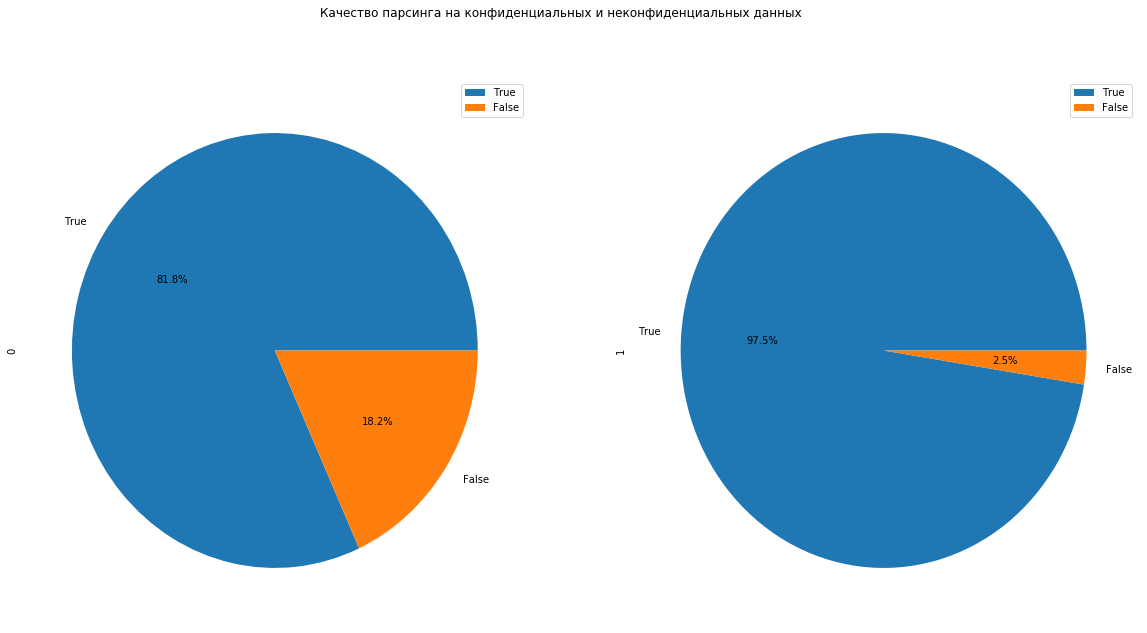

In [137]:
# df[['dtype', 'parsed']].mean()

pd.DataFrame({'0':d[d['y']==0]['parsed'].value_counts(), 
              '1':d[d['y']==1]['parsed'].value_counts()}).plot.pie(subplots = True, \
                                                                     title = 'Качество парсинга на конфиденциальных и неконфиденциальных данных',\
                                                                     figsize = (20, 10), \
                                                                     autopct='%2.1f%%')
plt.show()

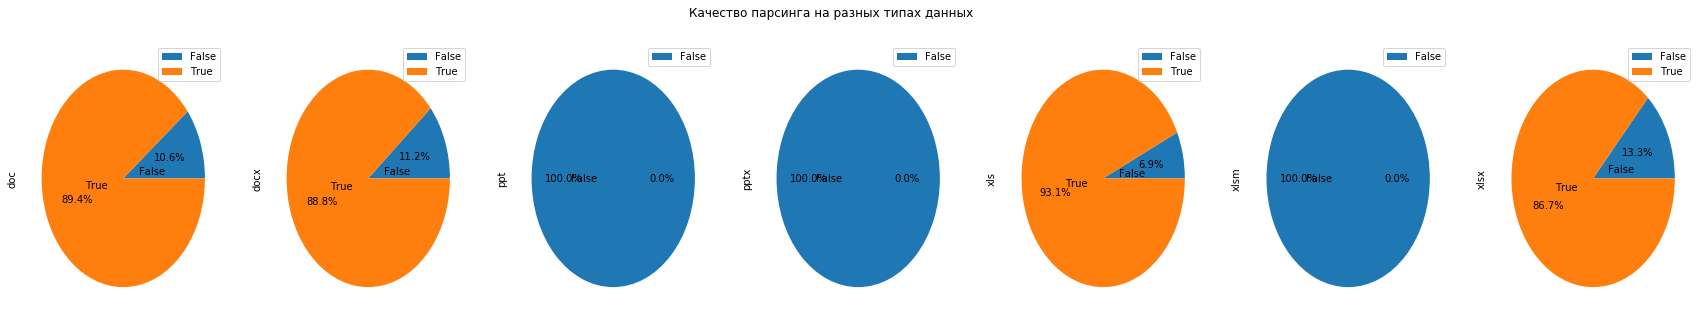

In [156]:
# df[['dtype', 'parsed']].mean()
# plt.pie()
pd.DataFrame({key:o['parsed'].value_counts() for key, o in d[d['permited_file_type']].groupby('type')}).plot.pie(subplots = True, \
                                                                     title = 'Качество парсинга на разных типах данных',\
                                                                     figsize = (30, 5), labeldistance = 0.2,\
                                                                     autopct='%2.1f%%')
plt.show()

Комментарий:
    - Хуже всего сработал парсинг для xlsx файлов
    - Необходимо добавить парсинг ppt/pptx фалов (конечную метрику он изменит не сильно)

### Размеры  классов

In [4]:
if df.index.dtype == np.dtype('O'):
    df = df.reset_index()
    
df = df[df['fn'].apply(lambda x:'~$' not in x)]
df['y'].value_counts()

0    32361
1      758
Name: y, dtype: int64

In [149]:
df[df['permited_file_type']]['y'].value_counts()

0    30473
1      747
Name: y, dtype: int64

#### Функция для подсчета основных метрик

In [77]:
# RESMETRICGLOBAL = {}

from sklearn.metrics import cohen_kappa_score, accuracy_score, precision_score, recall_score, average_precision_score,\
                            classification_report, roc_auc_score, \
                            precision_recall_fscore_support, confusion_matrix, \
                            roc_curve, precision_recall_curve
import pandas as pd           
metrics_y = {'cohen_kappa_score'       : cohen_kappa_score,
             'accuracy_score'          : accuracy_score,
             'precision_score'         : precision_score,
             'recall_score'            : recall_score,
            }

metrisc_p = {'roc_auc_score' : roc_auc_score,
             'average_precision_score' : average_precision_score
            }

def show_main_metrics(X_train, X_test, y_train, y_test, model, title = 'None'):
    p_train = model.predict_proba(X_train)[:, 1]
    p_test = model.predict_proba(X_test)[:, 1]
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    
    res = {'train' : {}, 'test' : {}}
    for metric_name, metric_funct in metrics_y.items():
        res['train'][metric_name] = metric_funct(y_train, pred_train)
        res['test'][metric_name]  = metric_funct(y_test, pred_test)
    
    for metric_name, metric_funct in metrisc_p.items():
        res['train'][metric_name] = metric_funct(y_train, p_train)
        res['test'][metric_name]  = metric_funct(y_test, p_test)
        
    res['train']['y'] = y_train
    res['test']['y']  = y_test
    
    res['train']['p'] = p_train
    res['test']['p']  = p_test
    
    res['train']['pred'] = pred_train
    res['test']['pred']  = pred_test
    print(classification_report(y_test, pred_test))
    M = confusion_matrix(y_test, pred_test)
    print("======\npred\\target   1         0\n")
    print("1             %d      %d"%(M[1,1], M[0,1]))
    print("0             %d      %d"%(M[1,0], M[0,0]))
    #print(((y_test == 1)&(pred_test == 0)).sum())
    RESMETRICGLOBAL[title] = res.copy()
    return pd.DataFrame(res)

#### Необходимо пороизвести корректное разбитие на train/test

#### Чтобы файлы из одних карточек в ЦЭОДО попадали в одну и ту же выборку 

In [197]:
# df

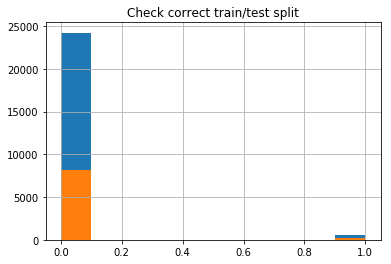

0.22870759889140674


In [144]:
df['folder_hash'] = df['fn'].apply(lambda x:x.split('/')[3].split('-')[0]).apply(lambda x: -hash(x))

# df['IDd'] = df.index
# df = df.reset_index()
# if IGONRE_NOT_PARSED_DOCEMENTS:
#     df = df[df['parsed'] == True]
# df['ID_HASH'] = df['fn'].apply(lambda x:hash(x.split('/')[-2][:36]))
q = df['folder_hash'].quantile(q = 1-alpha)
ind_train = df[df['folder_hash'] < q].index
ind_test  = df[df['folder_hash'] > q].index

plt.title('Check correct train/test split')
df.loc[ind_train, 'y'].hist()
df.loc[ind_test, 'y'].hist()
plt.show()
print((df.loc[ind_train, 'y'].mean()-df.loc[ind_test, 'y'].mean())/df['y'].mean())

### Dummy model
На вход тип документа/распарсился ли он/размер файла

In [88]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
model = CatBoostClassifier()
X_train = df.loc[ind_train, ['type', 'file_size', 'parsed']]
y_train = df.loc[ind_train, 'y']
X_test = df.loc[ind_test, ['type', 'file_size', 'parsed']]
y_test = df.loc[ind_test, 'y']


model.fit(X_train, y_train, cat_features = [0], verbose = False)
res_dummy_model = show_main_metrics(X_train, X_test, y_train, y_test, model, title = 'Dummy model')
res_dummy_model

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      8123
          1       0.00      0.00      0.00       157

avg / total       0.96      0.98      0.97      8280

pred\target   1         0

1             0      0
0             157      8123


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,test,train
accuracy_score,0.981039,0.975804
average_precision_score,0.0621874,0.092315
cohen_kappa_score,0,0
p,"[0.00022935630733783184, 0.0007356442456476679...","[0.0002513144836536345, 0.0007356442456476679,..."
precision_score,0,0
pred,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
recall_score,0,0
roc_auc_score,0.786714,0.805923
y,0 0 3 0 5 0 8 0 9 ...,1 0 2 0 4 0 6 0 7 ...


Комментарий:

    Модель не ловит зависимостей, и предсказывает все 0-м классом, это хорошо

### Лучшая модель с текущим уровнем парсинга

In [76]:
X_train = df.loc[ind_train, ['parsed', 'y']]
X_train['y'] = X_train['y']*X_train['parsed']
y_train = df.loc[ind_train, 'y']
X_test  = df.loc[ind_test, ['parsed', 'y']]
X_test['y'] = X_test['y']*X_test['parsed']
y_test  = df.loc[ind_test, 'y']

model = CatBoostClassifier()
model.fit(X_train, y_train, verbose = False)
show_main_metrics(X_train, X_test, y_train, y_test, model, title = 'Ideal model(with this parsing level)')



             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8077
          1       1.00      0.99      0.99       203

avg / total       1.00      1.00      1.00      8280

pred\target   1         0

1             200      0
0             3      8077
3


,test,train
accuracy_score,0.999638,0.999356
average_precision_score,0.98708,0.974352
cohen_kappa_score,0.99237,0.985046
p,"[4.894192222754353e-06, 4.894192222754353e-06,...","[0.003543301710129472, 0.003543301710129472, 4..."
precision_score,1,1
pred,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
recall_score,0.985222,0.971171
roc_auc_score,0.998709,0.997344
y,4 0 7 0 14 0 15 0 16...,0 0 1 0 2 0 3 0 5 ...


Комментарий:

    Даже с текущим уровнем парсинга, скорее всего можно существенно улучшить метрики модели

# Финальная часть: запустим на наших данных три модели
    - Логистическую регрессию
    - Random Forest
    - CatboostClassifier

### Логистическая регрессия

In [93]:
M = M.toarray()

In [91]:
# M[0, :].shape

In [145]:
X_train = M[ind_train, :]
X_test  = M[ind_test, :]
y_train = df.loc[ind_train, 'y']
y_test = df.loc[ind_test, 'y']

In [94]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
show_main_metrics(X_train, X_test, y_train, y_test, model, title = 'LogReg (tf-idf) (другое разбитие на train/test)')

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      8123
          1       0.99      0.61      0.75       157

avg / total       0.99      0.99      0.99      8280

pred\target   1         0

1             95      1
0             62      8122


,test,train
accuracy_score,0.992391,0.990579
average_precision_score,0.873616,0.889256
cohen_kappa_score,0.747353,0.758582
p,"[0.011921780911451463, 0.0052736366772149195, ...","[0.011921780911451463, 0.018867618037479276, 0..."
precision_score,0.989583,0.97416
pred,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
recall_score,0.605096,0.627288
roc_auc_score,0.973128,0.98345
y,0 0 3 0 5 0 8 0 9 ...,1 0 2 0 4 0 6 0 7 ...


In [95]:
N = 10
weigths = model.coef_[0]
indexes = np.argsort(weigths)
vocab = {v:k for k,v in vect.vocabulary_.items()}

print('\tTop %d non conf features'%N)
for ind in indexes[:N]:
    print("%s \t %f"%(vocab[ind], weigths[ind]))

print('\n\n\tTop %d conf features'%N)
for ind in indexes[-N:]:
    print("%s \t %f"%(vocab[ind], weigths[ind]))

	Top 10 non conf features
центр 	 -2.124025
ас 	 -1.970826
сотрудник 	 -1.904357
на 	 -1.874311
сопровождение 	 -1.832657
пцп 	 -1.830136
корпоративный 	 -1.800480
00 	 -1.798201
работа 	 -1.641533
операция 	 -1.437801


	Top 10 conf features
инсайдер 	 2.812079
заявка 	 2.874467
наличие 	 2.976036
экз 	 2.982245
скоринговый 	 3.199900
рк 	 3.442310
woe 	 3.556853
благонадежность 	 4.172301
участник 	 4.352095
конфиденциально 	 4.532273


Комментарий:

    Неплохо для первой модели
       precision > 0.95
       recall    > 0.5

### Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
show_main_metrics(X_train, X_test, y_train, y_test, model, title = 'RF (tf-idf) (другое разбитие на train/test)')


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8123
          1       0.99      0.77      0.87       157

avg / total       1.00      1.00      1.00      8280

pred\target   1         0

1             121      1
0             36      8122


,test,train
accuracy_score,0.995531,0.99851
average_precision_score,0.923995,0.97311
cohen_kappa_score,0.865147,0.967478
p,"[0.004167179947997465, 0.0, 0.0, 0.0, 0.0, 0.2...","[0.004167179947997465, 0.0, 0.0, 0.0, 0.0, 0.0..."
precision_score,0.991803,1
pred,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
recall_score,0.770701,0.938436
roc_auc_score,0.985953,0.99644
y,0 0 3 0 5 0 8 0 9 ...,1 0 2 0 4 0 6 0 7 ...


In [97]:
N = 10
weigths = model.feature_importances_
indexes = np.argsort(weigths)
vocab = {v:k for k,v in vect.vocabulary_.items()}

print('\n\n\tTop %d features'%N)
for ind in indexes[-N:]:
    print("%s \t %f"%(vocab[ind], weigths[ind]))



	Top 10 features
асташкин 	 0.010387
интегральный 	 0.010841
экз 	 0.010847
score 	 0.012205
ведяхин 	 0.012715
____________________ 	 0.013143
sum 	 0.013429
конфиденциально 	 0.014404
_______________________ 	 0.023866
скоринговый 	 0.026255


### Gradient boosting (cat boost)

In [146]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations = 100, verbose = True)
model.fit(X_train, y_train)
show_main_metrics(X_train, X_test, y_train, y_test, model, title = 'Gradient boosting (tf-idf) (другое разбитие на train/test)')

Borders for float features generated
0:	learn 0.6336969949	total: 10.6s	remaining: 17m 25s
1:	learn 0.587497508	total: 20.9s	remaining: 17m 4s
2:	learn 0.5382087196	total: 30.9s	remaining: 16m 39s
3:	learn 0.4927449006	total: 40.8s	remaining: 16m 19s
4:	learn 0.4493094844	total: 50.5s	remaining: 15m 59s
5:	learn 0.4133276942	total: 1m	remaining: 15m 43s
6:	learn 0.382078285	total: 1m 11s	remaining: 15m 45s
7:	learn 0.3512442312	total: 1m 23s	remaining: 15m 59s
8:	learn 0.3248314991	total: 1m 35s	remaining: 16m 2s
9:	learn 0.3013136274	total: 1m 46s	remaining: 15m 56s
10:	learn 0.2816701096	total: 1m 56s	remaining: 15m 43s
11:	learn 0.2606905415	total: 2m 7s	remaining: 15m 32s
12:	learn 0.2423273975	total: 2m 18s	remaining: 15m 26s
13:	learn 0.2248210472	total: 2m 28s	remaining: 15m 11s
14:	learn 0.2097968424	total: 2m 39s	remaining: 15m 1s
15:	learn 0.1952155283	total: 2m 49s	remaining: 14m 48s
16:	learn 0.1832654731	total: 2m 59s	remaining: 14m 36s
17:	learn 0.1704557048	total: 3m 9s	

,test,train
accuracy_score,0.99372,0.992109
average_precision_score,0.908234,0.89564
cohen_kappa_score,0.80981,0.805794
p,"[0.011963810652930685, 0.008644863871740108, 0...","[0.011963810652930685, 0.008430899377365377, 0..."
precision_score,0.933884,0.972028
pred,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
recall_score,0.719745,0.693844
roc_auc_score,0.988521,0.978059
y,0 0 3 0 5 0 8 0 9 ...,1 0 2 0 4 0 6 0 7 ...


In [150]:
N = 50
weigths = model.feature_importances_
indexes = np.argsort(weigths)
vocab = {v:k for k,v in vect.vocabulary_.items()}

print('\n\n\tTop %d features (Catboost)'%N)
for ind in indexes[-N:]:
    print("%s \t %f"%(vocab[ind], weigths[ind]))



	Top 50 features (Catboost)
балл 	 0.205982
вероятность 	 0.206980
модуль 	 0.214271
do 	 0.224452
missing 	 0.224453
age 	 0.229650
кредит 	 0.268482
утверждать 	 0.285172
учредитель 	 0.287277
наличие 	 0.288779
сентябрь 	 0.299623
возврат 	 0.308101
или 	 0.355042
влиять 	 0.374412
правоохранительный 	 0.380795
со 	 0.399665
вычисляться 	 0.426251
заявка 	 0.431660
настоящий 	 0.450532
асташкин 	 0.521853
пп 	 0.524558
формат 	 0.582422
инсайдерский 	 0.586069
работа 	 0.639135
участник 	 0.651000
sum 	 0.674903
ню 	 0.687991
рк 	 0.740899
малый 	 0.741273
инцидент 	 0.785215
дефолт 	 0.804439
редакция 	 0.847539
распоряжение 	 0.973612
экз 	 0.990397
фиктивность 	 1.031785
кредитный 	 1.227530
центр 	 1.268087
tsm 	 1.279114
сделка 	 1.343091
подразделение 	 1.632380
woe 	 1.765695
работодатель 	 2.143847
score 	 2.194814
назначать 	 2.679023
корпоративный 	 2.884783
скоринговый 	 5.663838
система 	 7.382273
контроль 	 9.021655
благонадежность 	 9.458813
конфиденциально 	 25.0584

# Финальная таблица с метриками

In [114]:
def show_all_metric(metric_name = 'cohen_kappa_score'):
    def foo(x, metric = 'cohen_kappa_score'):
        return [x['train'][metric], x['test'][metric]]
    return pd.DataFrame.from_dict(RESMETRICGLOBAL).apply(lambda x: foo(x, metric_name))

In [151]:
show_all_metric('cohen_kappa_score')

,Dummy model,Gradient boosting (tf-idf),Gradient boosting (tf-idf) (другое разбитие на train/test),Ideal model(with this parsing level),LogReg (tf-idf),LogReg (tf-idf) (другое разбитие на train/test),RF (tf-idf),RF (tf-idf) (другое разбитие на train/test)
test,0.0,0.802636,0.805794,0.985046,0.754616,0.758582,0.967703,0.967478
train,0.0,0.817125,0.809810,0.992370,0.665156,0.747353,0.840183,0.865147


In [152]:
show_all_metric('accuracy_score')

,Dummy model,Gradient boosting (tf-idf),Gradient boosting (tf-idf) (другое разбитие на train/test),Ideal model(with this parsing level),LogReg (tf-idf),LogReg (tf-idf) (другое разбитие на train/test),RF (tf-idf),RF (tf-idf) (другое разбитие на train/test)
test,0.975804,0.991988,0.992109,0.999356,0.991223,0.990579,0.998631,0.998510
train,0.981039,0.993961,0.993720,0.999638,0.987560,0.992391,0.993237,0.995531


In [153]:
show_all_metric('precision_score')

,Dummy model,Gradient boosting (tf-idf),Gradient boosting (tf-idf) (другое разбитие на train/test),Ideal model(with this parsing level),LogReg (tf-idf),LogReg (tf-idf) (другое разбитие на train/test),RF (tf-idf),RF (tf-idf) (другое разбитие на train/test)
test,0.0,0.969626,0.972028,1.0,0.982808,0.974160,1.000000,1.000000
train,0.0,0.942149,0.933884,1.0,0.954545,0.989583,0.974194,0.991803


In [154]:
show_all_metric('recall_score')

,Dummy model,Gradient boosting (tf-idf),Gradient boosting (tf-idf) (другое разбитие на train/test),Ideal model(with this parsing level),LogReg (tf-idf),LogReg (tf-idf) (другое разбитие на train/test),RF (tf-idf),RF (tf-idf) (другое разбитие на train/test)
test,0.0,0.690516,0.693844,0.971171,0.618018,0.627288,0.938739,0.938436
train,0.0,0.726115,0.719745,0.985222,0.517241,0.605096,0.743842,0.770701


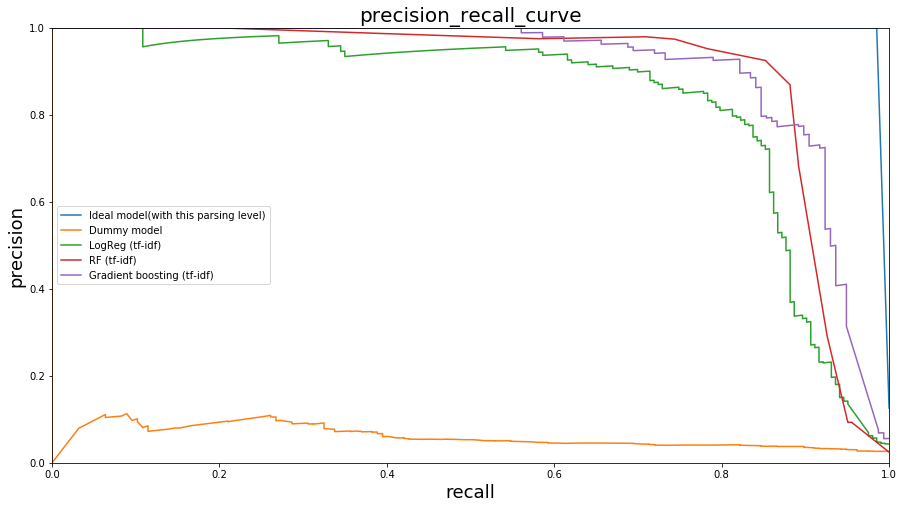

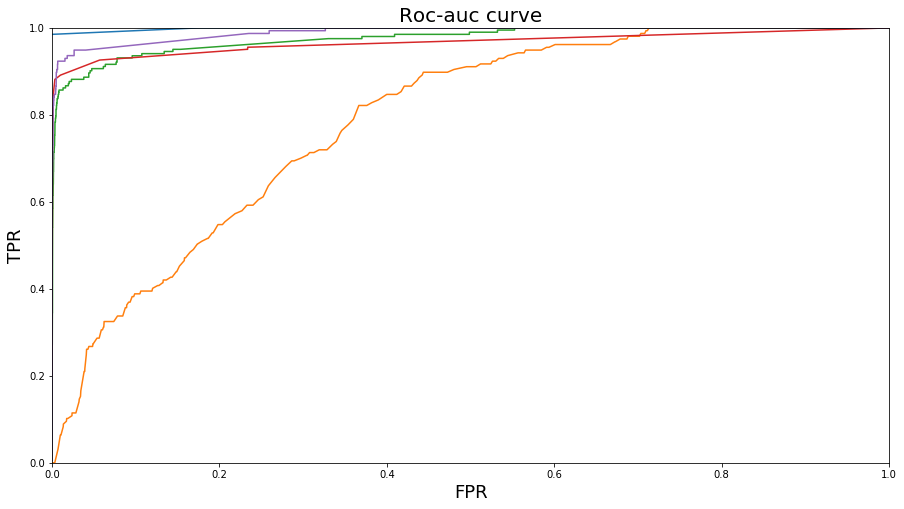

In [169]:
plt.figure(figsize = (15, 8))
for _name in RESMETRICGLOBAL.keys():
    if 'другое разбитие на train/test' in _name:
        continue
    _y = RESMETRICGLOBAL[_name]['test']['y']
    _p = RESMETRICGLOBAL[_name]['test']['p']
# .T['test']['y_test']
# _p = RESMETRICGLOBAL['Gradient boosting (tf-idf)'].T['test']['p_test']
    precision, recall, thresholds = precision_recall_curve(_y, _p)
    plt.plot(recall, precision, label = _name)
plt.xlabel('recall', fontsize = 18)
plt.ylabel('precision', fontsize = 18)
plt.title('precision_recall_curve', fontsize = 20)
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


plt.figure(figsize = (15, 8))
for _name in RESMETRICGLOBAL.keys():
    if 'другое разбитие на train/test' in _name:
        continue
    _y = RESMETRICGLOBAL[_name]['test']['y']
    _p = RESMETRICGLOBAL[_name]['test']['p']
    fpr, tpr, thresholds  = roc_curve(_y, _p)
    plt.plot(fpr, tpr)
    
plt.xlabel('FPR', fontsize = 18)
plt.ylabel('TPR', fontsize = 18)
plt.title('Roc-auc curve', fontsize = 20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()